In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Standard imports
import logging
import itertools
import random
from pprint import pprint

logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', level=logging.INFO)

# Dependecy imports
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, Dropout, BatchNormalization
from keras.optimizers import adam
import keras.backend.tensorflow_backend as K
from keras import initializers, regularizers

# Hyperparameter tuning
from livelossplot import PlotLossesKeras

# Set Keras TF backend allow_growth not to consume all GPU memory
# K_CONFIG = K.tf.ConfigProto()
# K_CONFIG.allow_soft_placement = True
# K_CONFIG.gpu_options.allow_growth = True # pylint: disable=E1101
# K.set_session(K.tf.Session(config=K_CONFIG))

# Local imports
from utils.data import Generator, Augmentation
from utils.visualization import pim, plot_confusion_matrix
from utils.keras_utils import save_keras_model

from models.keras_net_defs import conv3d_model

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Train generator and Valid data

In [2]:
CLASS_MAPS = {1: 0, 3: 1, 4: 2, 999: 4}

train_generator = Generator(
    class_maps=CLASS_MAPS,
    nb_time=1,
    reg_size=15,
    vegetation_layers=False,
    data_dir='../data/_train/',
    batch_size=128,
    batch_size_polygons=200
)


sample_size = 1000000 # The highest better
train_generator.norms_and_weights(sample_size)
train_gen = train_generator.from_files(norm=True, augment=True)

NORMS = train_generator.norms
CLASS_WEIGHT = train_generator.class_weight

pprint(NORMS)
pprint(CLASS_WEIGHT)

2018-06-05 19:15:35,282 INFO: number of directories found 354


{'total': 999936, 0: 414487, 1: 508370, 2: 77079}
{0: [0.0, 351.0, 118.0237055171531],
 1: [0.0, 842.0, 216.08301331285202],
 2: [0.0, 2926.0, 755.6997567844342],
 3: [0.0, 4146.0, 1574.7520481310803],
 4: [0.0, 5197.0, 1851.952892985151],
 5: [0.0, 5529.0, 2052.6966205837175],
 6: [0.0, 4315.0, 1109.224398361495],
 7: [0.0, 3839.0, 550.2943548387096],
 8: [0.0, 2853.0, 468.9477086533538],
 9: [0.0, 2398.0, 692.8005632360471],
 10: [0.0, 2275.0, 834.3107398873528],
 11: [0.0, 4812.0, 1825.784178187404]}
{0: 2.412466494727217, 1: 1.9669453350905837, 2: 12.972871988479353}


In [3]:
valid_generator = Generator(
    class_maps=CLASS_MAPS,
    norms=NORMS,
    nb_time=1,
    reg_size=15,
    vegetation_layers=False,
    data_dir='../data/_valid/',
    batch_size=10000,
    batch_size_polygons=100
)

valid_gen = valid_generator.from_files(norm=True, augment=False)
valid_data, valid_labels = next(valid_gen)
print(valid_data.shape, valid_labels.shape)

def n_unique(arr, val_dict):
    """Count unique values"""
    bincount = np.bincount(arr)
    b_ii = np.nonzero(bincount)[0]

    for val, count in zip(b_ii, bincount[b_ii]):

        if val not in val_dict:
            val_dict[val] = count
        else:
            val_dict[val] += count

    return val_dict

unique_classes = n_unique(np.argmax(valid_labels, axis=1), {})
vals = [val for val in unique_classes.values()]

pprint(unique_classes)
print(f'Best guess: {round(100 * max(vals) / sum(vals), 2)}%')

2018-06-05 19:16:08,054 INFO: number of directories found 22


(4080, 1, 15, 15, 12) (4080, 4)
{0: 733, 1: 2410, 2: 937}
Best guess: 59.07%


# Augment trainset

We can generate more train data by rotating 3 times by 90 degrees and then flip and then flip rotated image by 180 degrees

1. original
2. 1 x rot90
3. 2 x rot90
4. 3 x rot90
5. flip original
6. flip original and rotate 180

## Testing augmentation

In [4]:
augm = Augmentation()

2018-06-05 19:16:08,278 INFO: number of directories found 354


Comparing each element with eachother to check if augmentation didnt create duplicates
False False False False False False False False False False False False False False False 

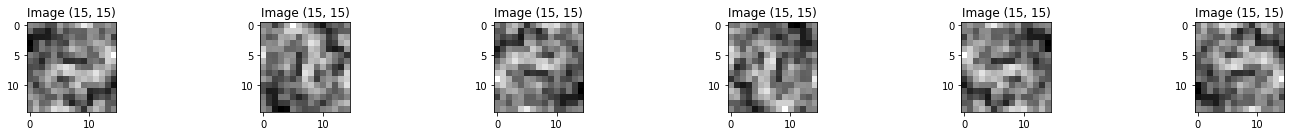

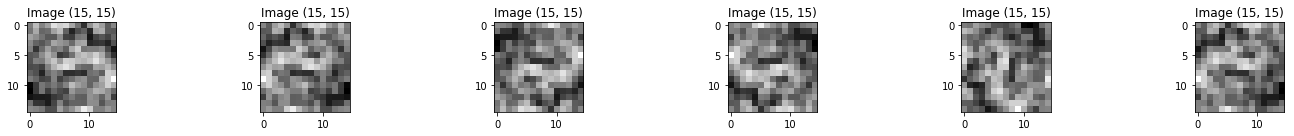

In [5]:
test_sample = next(train_gen)[0][0:1]

orig = test_sample[0, 0, :, :, 0]
rot_90 = augm.rot90(test_sample)[0, 0, :, :, 0]
rot_180 = augm.rot180(test_sample)[0, 0, :, :, 0]
rot_270 = augm.rot270(test_sample)[0, 0, :, :, 0]
flip = augm.flip(test_sample)[0, 0, :, :, 0]
flip180 = augm.flip_rot90(test_sample)[0, 0, :, :, 0]

plot_sampels = [orig, rot_90, rot_180, rot_270, flip, flip180]
random_samples = [augm.random_augm(test_sample)[0, 0, :, :, 0] for _ in range(6)]

print('Comparing each element with eachother to check if augmentation didnt create duplicates')
for smpl_0, smpl_1 in itertools.combinations(plot_sampels, 2):
    print(np.array_equal(smpl_0, smpl_1), end=' ')

pim(plot_sampels)
pim(random_samples)

In [7]:
def train_model_gen(data_dir, norms, class_maps, params, steps_per_epoch):
    
    keras_model = conv3d_model(4, params, summary=True)

    history = keras_model.fit_generator(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=params['epochs'],
        verbose=1,
        validation_data=(valid_data, valid_labels),
        class_weight=CLASS_WEIGHT,
        shuffle=True,
        workers=8,
        max_queue_size=int(steps_per_epoch * 2.2), # How many batches in the queue
        # callbacks=[PlotLossesKeras()]
    )
    
    return history, keras_model

### 1. place

```
06/03/2018 12:56:53 AM - INFO - {'__cnn_dropout_1': 0.3, '__cnn_dropout_2': 0.7, '__cnn_dropout_3': 0.2, '__cnn_dropout_4': 0.5, '__cnn_ksize_1': 1, '__cnn_ksize_2': 6, '__cnn_ksize_3': 5, '__cnn_ksize_4': 6, '__cnn_neurons_1': 512, '__cnn_neurons_2': 128, '__cnn_neurons_3': 16, '__cnn_neurons_4': 128, '__dense_dropout_1': 0.8, '__dense_dropout_2': 0.8, '__dense_dropout_3': 0.8, '__dense_dropout_4': 0.3, '__dense_neurons_1': 128, '__dense_neurons_2': 8, '__dense_neurons_3': 16, '__dense_neurons_4': 32, 'activation_cnn': 'relu', 'activation_dense': 'elu', 'batch_norm': True, 'batch_size': 128, 'class_weight': True, 'dshape': (1, 15, 15, 12), 'epochs': 20, 'l2_reg': 0.001, 'l_r': 1e-05, 'nb_cnn_layers': 2, 'nb_dense_layers': 1, '__dense_neurons': [], '__cnn_neurons': [512]}
06/03/2018 12:56:53 AM - INFO - Acc: 87.26%
06/03/2018 12:56:53 AM - INFO - UniID: 781
06/03/2018 12:56:53 AM - INFO - Mom and Dad: 596 667
06/03/2018 12:56:53 AM - INFO - Gen: 8
06/03/2018 12:56:53 AM - INFO - Hash: 1a788475ba8075ec5bedffd4b2408c38
```

In [8]:
PARAMS_1 = {
    '__cnn_dropout_1': 0.3, '__cnn_dropout_2': 0.7, '__cnn_dropout_3': 0.2, '__cnn_dropout_4': 0.5,
    '__cnn_ksize_1': 1, '__cnn_ksize_2': 6, '__cnn_ksize_3': 5, '__cnn_ksize_4': 6,
    '__cnn_neurons_1': 512, '__cnn_neurons_2': 128, '__cnn_neurons_3': 16, '__cnn_neurons_4': 128,
    '__dense_dropout_1': 0.8, '__dense_dropout_2': 0.8, '__dense_dropout_3': 0.8, '__dense_dropout_4': 0.3,
    '__dense_neurons_1': 128, '__dense_neurons_2': 8, '__dense_neurons_3': 16, '__dense_neurons_4': 32,
    'activation_cnn': 'relu',
    'activation_dense': 'elu',
    'batch_norm': True,
    'batch_size': 128,
    'class_weight': True,
    'dshape': (1, 15, 15, 12),
    'epochs': 12,
    'l2_reg': 0.001,
    'l_r': 1e-05,
    'nb_cnn_layers': 2,
    'nb_dense_layers': 1,
}

### 2. place

```
06/03/2018 12:56:53 AM - INFO - {'__cnn_dropout_1': 0.0, '__cnn_dropout_2': 0.7, '__cnn_dropout_3': 0.2, '__cnn_dropout_4': 0.5, '__cnn_ksize_1': 4, '__cnn_ksize_2': 4, '__cnn_ksize_3': 5, '__cnn_ksize_4': 5, '__cnn_neurons_1': 128, '__cnn_neurons_2': 8, '__cnn_neurons_3': 32, '__cnn_neurons_4': 512, '__dense_dropout_1': 0.0, '__dense_dropout_2': 0.7, '__dense_dropout_3': 0.5, '__dense_dropout_4': 0.3, '__dense_neurons_1': 512, '__dense_neurons_2': 32, '__dense_neurons_3': 8, '__dense_neurons_4': 128, 'activation_cnn': 'relu', 'activation_dense': 'elu', 'batch_norm': True, 'batch_size': 128, 'class_weight': True, 'dshape': (1, 15, 15, 12), 'epochs': 20, 'l2_reg': 0.01, 'l_r': 1e-05, 'nb_cnn_layers': 2, 'nb_dense_layers': 1, '__dense_neurons': [], '__cnn_neurons': [128]}
06/03/2018 12:56:53 AM - INFO - Acc: 87.09%
06/03/2018 12:56:53 AM - INFO - UniID: 636
06/03/2018 12:56:53 AM - INFO - Mom and Dad: 551 568
06/03/2018 12:56:53 AM - INFO - Gen: 7
06/03/2018 12:56:53 AM - INFO - Hash: ce9584dd64840a975600b008f9215b2c
```

In [9]:
PARAMS_2 = {
    '__cnn_dropout_1': 0.0, '__cnn_dropout_2': 0.7, '__cnn_dropout_3': 0.2, '__cnn_dropout_4': 0.5,
    '__cnn_ksize_1': 4, '__cnn_ksize_2': 4, '__cnn_ksize_3': 5, '__cnn_ksize_4': 5,
    '__cnn_neurons_1': 128, '__cnn_neurons_2': 8, '__cnn_neurons_3': 32, '__cnn_neurons_4': 512,
    '__dense_dropout_1': 0.0, '__dense_dropout_2': 0.7, '__dense_dropout_3': 0.5, '__dense_dropout_4': 0.3,
    '__dense_neurons_1': 512, '__dense_neurons_2': 32, '__dense_neurons_3': 8, '__dense_neurons_4': 128,
    'activation_cnn': 'relu',
    'activation_dense': 'elu',
    'batch_norm': True,
    'batch_size': 128,
    'class_weight': True,
    'dshape': (1, 15, 15, 12),
    'epochs': 30,
    'l2_reg': 0.01,
    'l_r': 1e-05,
    'nb_cnn_layers': 2,
    'nb_dense_layers': 1
}

### 3. place

```
06/03/2018 12:56:53 AM - INFO - {'__cnn_dropout_1': 0.0, '__cnn_dropout_2': 0.2, '__cnn_dropout_3': 0.2, '__cnn_dropout_4': 0.5, '__cnn_ksize_1': 4, '__cnn_ksize_2': 4, '__cnn_ksize_3': 5, '__cnn_ksize_4': 5, '__cnn_neurons_1': 512, '__cnn_neurons_2': 128, '__cnn_neurons_3': 512, '__cnn_neurons_4': 4, '__dense_dropout_1': 0.8, '__dense_dropout_2': 0.8, '__dense_dropout_3': 0.8, '__dense_dropout_4': 0.3, '__dense_neurons_1': 128, '__dense_neurons_2': 256, '__dense_neurons_3': 4, '__dense_neurons_4': 4, 'activation_cnn': 'relu', 'activation_dense': 'elu', 'batch_norm': True, 'batch_size': 128, 'class_weight': True, 'dshape': (1, 15, 15, 12), 'epochs': 20, 'l2_reg': 1, 'l_r': 1e-05, 'nb_cnn_layers': 2, 'nb_dense_layers': 1, '__dense_neurons': [], '__cnn_neurons': [512]}
06/03/2018 12:56:53 AM - INFO - Acc: 86.96%
06/03/2018 12:56:53 AM - INFO - UniID: 798
06/03/2018 12:56:53 AM - INFO - Mom and Dad: 636 690
06/03/2018 12:56:53 AM - INFO - Gen: 8
06/03/2018 12:56:53 AM - INFO - Hash: 2b24ffadb675e226397d3c1f23f74737
```

In [10]:
PARAMS_3 = {
    '__cnn_dropout_1': 0.0, '__cnn_dropout_2': 0.2, '__cnn_dropout_3': 0.2, '__cnn_dropout_4': 0.5,
    '__cnn_ksize_1': 4, '__cnn_ksize_2': 4, '__cnn_ksize_3': 5, '__cnn_ksize_4': 5,
    '__cnn_neurons_1': 512, '__cnn_neurons_2': 128, '__cnn_neurons_3': 512, '__cnn_neurons_4': 4,
    '__dense_dropout_1': 0.8, '__dense_dropout_2': 0.8, '__dense_dropout_3': 0.8, '__dense_dropout_4': 0.3,
    '__dense_neurons_1': 128, '__dense_neurons_2': 256, '__dense_neurons_3': 4, '__dense_neurons_4': 4,
    'activation_cnn': 'relu',
    'activation_dense': 'elu',
    'batch_norm': True,
    'batch_size': 128,
    'class_weight': True,
    'dshape': (1, 15, 15, 12),
    'epochs': 20,
    'l2_reg': 1,
    'l_r': 1e-05,
    'nb_cnn_layers': 2,
    'nb_dense_layers': 1
}

### 4. place

```
06/03/2018 12:56:53 AM - INFO - {'__cnn_dropout_1': 0.3, '__cnn_dropout_2': 0.7, '__cnn_dropout_3': 0.2, '__cnn_dropout_4': 0.5, '__cnn_ksize_1': 1, '__cnn_ksize_2': 6, '__cnn_ksize_3': 5, '__cnn_ksize_4': 6, '__cnn_neurons_1': 512, '__cnn_neurons_2': 128, '__cnn_neurons_3': 16, '__cnn_neurons_4': 128, '__dense_dropout_1': 0.8, '__dense_dropout_2': 0.8, '__dense_dropout_3': 0.8, '__dense_dropout_4': 0.3, '__dense_neurons_1': 128, '__dense_neurons_2': 8, '__dense_neurons_3': 16, '__dense_neurons_4': 32, 'activation_cnn': 'relu', 'activation_dense': 'elu', 'batch_norm': True, 'batch_size': 128, 'class_weight': True, 'dshape': (1, 15, 15, 12), 'epochs': 20, 'l2_reg': 0.01, 'l_r': 1e-05, 'nb_cnn_layers': 2, 'nb_dense_layers': 1, '__dense_neurons': [], '__cnn_neurons': [512]}
06/03/2018 12:56:53 AM - INFO - Acc: 86.92%
06/03/2018 12:56:53 AM - INFO - UniID: 667
06/03/2018 12:56:53 AM - INFO - Mom and Dad: 614 359
06/03/2018 12:56:53 AM - INFO - Gen: 7
06/03/2018 12:56:53 AM - INFO - Hash: c33634763d76d8de368bb42a89c3e262
```

In [11]:
PARAMS_4 = {
    '__cnn_dropout_1': 0.3, '__cnn_dropout_2': 0.7, '__cnn_dropout_3': 0.2, '__cnn_dropout_4': 0.5,
    '__cnn_ksize_1': 1, '__cnn_ksize_2': 6, '__cnn_ksize_3': 5, '__cnn_ksize_4': 6,
    '__cnn_neurons_1': 512, '__cnn_neurons_2': 128, '__cnn_neurons_3': 16, '__cnn_neurons_4': 128,
    '__dense_dropout_1': 0.8, '__dense_dropout_2': 0.8, '__dense_dropout_3': 0.8, '__dense_dropout_4': 0.3,
    '__dense_neurons_1': 128, '__dense_neurons_2': 8, '__dense_neurons_3': 16, '__dense_neurons_4': 32,
    'activation_cnn': 'relu',
    'activation_dense': 'elu',
    'batch_norm': True,
    'batch_size': 128,
    'class_weight': True,
    'dshape': (1, 15, 15, 12),
    'epochs': 20,
    'l2_reg': 0.01,
    'l_r': 1e-05,
    'nb_cnn_layers': 2,
    'nb_dense_layers': 1
}

### 5. place

```
06/03/2018 12:56:53 AM - INFO - {'__cnn_dropout_1': 0.0, '__cnn_dropout_2': 0.5, '__cnn_dropout_3': 0.2, '__cnn_dropout_4': 0.8, '__cnn_ksize_1': 7, '__cnn_ksize_2': 2, '__cnn_ksize_3': 3, '__cnn_ksize_4': 6, '__cnn_neurons_1': 512, '__cnn_neurons_2': 128, '__cnn_neurons_3': 512, '__cnn_neurons_4': 128, '__dense_dropout_1': 0.8, '__dense_dropout_2': 0.8, '__dense_dropout_3': 0.8, '__dense_dropout_4': 0.3, '__dense_neurons_1': 128, '__dense_neurons_2': 256, '__dense_neurons_3': 4, '__dense_neurons_4': 4, 'activation_cnn': 'relu', 'activation_dense': 'elu', 'batch_norm': True, 'batch_size': 128, 'class_weight': True, 'dshape': (1, 15, 15, 12), 'epochs': 20, 'l2_reg': 1, 'l_r': 1e-05, 'nb_cnn_layers': 2, 'nb_dense_layers': 1, '__dense_neurons': [], '__cnn_neurons': [512]}
06/03/2018 12:56:53 AM - INFO - Acc: 86.49%
06/03/2018 12:56:53 AM - INFO - UniID: 402
06/03/2018 12:56:53 AM - INFO - Mom and Dad: 262 282
06/03/2018 12:56:53 AM - INFO - Gen: 4
06/03/2018 12:56:53 AM - INFO - Hash: 06b597f8388685bbcdb0423f4aa42021
```

In [12]:
PARAMS_5 = {
    '__cnn_dropout_1': 0.0, '__cnn_dropout_2': 0.5, '__cnn_dropout_3': 0.2, '__cnn_dropout_4': 0.8,
    '__cnn_ksize_1': 7, '__cnn_ksize_2': 2, '__cnn_ksize_3': 3, '__cnn_ksize_4': 6,
    '__cnn_neurons_1': 512, '__cnn_neurons_2': 128, '__cnn_neurons_3': 512, '__cnn_neurons_4': 128,
    '__dense_dropout_1': 0.8, '__dense_dropout_2': 0.8, '__dense_dropout_3': 0.8, '__dense_dropout_4': 0.3,
    '__dense_neurons_1': 128, '__dense_neurons_2': 256, '__dense_neurons_3': 4, '__dense_neurons_4': 4,
    'activation_cnn': 'relu',
    'activation_dense': 'elu',
    'batch_norm': True,
    'batch_size': 128,
    'class_weight': True,
    'dshape': (1, 15, 15, 12),
    'epochs': 20,
    'l2_reg': 1,
    'l_r': 1e-05,
    'nb_cnn_layers': 2,
    'nb_dense_layers': 1
}

In [13]:
K.clear_session()

history, keras_model = train_model_gen(
    data_dir='../data/_train/',
    norms=NORMS,
    class_maps=CLASS_MAPS,
    params=PARAMS_2,
    steps_per_epoch=250
);

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 1, 12, 12, 128)    24704     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 12, 12, 128)    512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 1, 9, 9, 8)        16392     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 9, 9, 8)        32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 9, 9, 8)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 648)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               332288    
__________

# What happens when channels one-by-one are being replaced by 0 values?

In [16]:
channel_translate = {
    0: 'S1_VH',
    1: 'S1_VV',
    2: '(B5, 20m res) 705 nm (Vegetation classification, near infrared)',
    3: '(B6, 20m res) 740 nm (Vegetation classification, near infrared)',
    4: '(B7, 20m res) 783 nm (Water vapour)',
    5: '(B8a, 20m res) 865 nm (Vegetation classification, near infrared)',
    6: '(B11, 20m res) 1610 nm (Snow / ice / cloud discrimination, shortwave infrared)',
    7: '(B12, 20m res) 2190 nm (Snow / ice / cloud discrimination, shortwave infrared)',
    8: '(B2, 10m res)  490 nm (blue)',
    9: '(B3, 10m res) 560 nm (green)',
    10: '(B4, 10m res) 665 nm (red)',
    11: '(B8, 10m res) 842 nm (Vegetation classification, near infrared)',
    12: 'ndvi',
    13: 'ndwi',
}

results = keras_model.evaluate(valid_data, valid_labels, verbose=9)

all_acc = round(results[1] * 100, 2)
print('Channel: all Validation Loss:', round(results[0], 2),
      'Validation Precision:', all_acc)

for ch_nr in range(valid_data.shape[4]):
    
    test_data = valid_data.copy()
    test_data[:, :, :, :, ch_nr] = 0

    results = keras_model.evaluate(test_data, valid_labels, verbose=9)
    ch_acc = round(results[1] * 100, 2)
    
    print('Channel:', str(ch_nr).ljust(3), 'Validation Loss:', round(results[0], 2),
          'Validation Precision:', str(ch_acc).ljust(5), f'[{round(ch_acc - all_acc, 2)}]'.ljust(7),
          f'---> {channel_translate[ch_nr]}')

Channel: all Validation Loss: 1.07 Validation Precision: 72.25
Channel: 0   Validation Loss: 1.06 Validation Precision: 72.43 [0.18]  ---> S1_VH
Channel: 1   Validation Loss: 1.27 Validation Precision: 70.07 [-2.18] ---> S1_VV
Channel: 2   Validation Loss: 1.83 Validation Precision: 42.5  [-29.75] ---> (B5, 20m res) 705 nm (Vegetation classification, near infrared)
Channel: 3   Validation Loss: 3.87 Validation Precision: 52.35 [-19.9] ---> (B6, 20m res) 740 nm (Vegetation classification, near infrared)
Channel: 4   Validation Loss: 3.36 Validation Precision: 46.08 [-26.17] ---> (B7, 20m res) 783 nm (Water vapour)
Channel: 5   Validation Loss: 2.17 Validation Precision: 46.99 [-25.26] ---> (B8a, 20m res) 865 nm (Vegetation classification, near infrared)
Channel: 6   Validation Loss: 3.78 Validation Precision: 30.02 [-42.23] ---> (B11, 20m res) 1610 nm (Snow / ice / cloud discrimination, shortwave infrared)
Channel: 7   Validation Loss: 1.18 Validation Precision: 72.82 [0.57]  ---> (B12,

# Find best accuracy recall combo

In [18]:
preds = keras_model.predict(valid_data)
flat_preds = np.argmax(preds, axis=1)
probs = preds.max(axis=1)

results = keras_model.evaluate(valid_data, valid_labels)
print('Validation Loss:', results[0], 'Validation Precision:', results[1])

4080/4080 [==============================] - 1s 237us/step
Validation Loss: 1.0650845494924808 Validation Precision: 0.7225490196078431


In [19]:
for acc in np.arange(0.8, 1, 0.01):
    high_precision = np.argwhere(probs > acc).flatten()

    flat_labels = np.argmax(valid_labels[high_precision], axis=1)
    
    pred_good = np.sum(flat_labels == flat_preds[high_precision])
    accuracy = pred_good / high_precision.shape[0]
    recall = high_precision.shape[0] / probs.shape[0]
    
    bincount = np.bincount(flat_labels.astype(np.int64))
    i_i = np.nonzero(bincount)[0]
    zip_bin = list(zip(i_i, bincount[i_i]))

    print(f"Probs > {str(round(acc, 3)).ljust(4)} --> Acc: {str(round(accuracy, 3)).ljust(5)} "
          f"Recall: {str(round(recall, 3)).ljust(10)} | Distribution: {zip_bin}")

Probs > 0.8  --> Acc: 0.941 Recall: 0.422      | Distribution: [(0, 416), (1, 907), (2, 398)]
Probs > 0.81 --> Acc: 0.944 Recall: 0.404      | Distribution: [(0, 404), (1, 852), (2, 392)]
Probs > 0.82 --> Acc: 0.947 Recall: 0.382      | Distribution: [(0, 398), (1, 785), (2, 375)]
Probs > 0.83 --> Acc: 0.947 Recall: 0.359      | Distribution: [(0, 382), (1, 720), (2, 361)]
Probs > 0.84 --> Acc: 0.952 Recall: 0.337      | Distribution: [(0, 364), (1, 667), (2, 344)]
Probs > 0.85 --> Acc: 0.952 Recall: 0.319      | Distribution: [(0, 344), (1, 630), (2, 329)]
Probs > 0.86 --> Acc: 0.957 Recall: 0.3        | Distribution: [(0, 333), (1, 578), (2, 312)]
Probs > 0.87 --> Acc: 0.96  Recall: 0.275      | Distribution: [(0, 311), (1, 518), (2, 291)]
Probs > 0.88 --> Acc: 0.965 Recall: 0.239      | Distribution: [(0, 282), (1, 421), (2, 274)]
Probs > 0.89 --> Acc: 0.967 Recall: 0.2        | Distribution: [(0, 244), (1, 313), (2, 257)]
Probs > 0.9  --> Acc: 0.962 Recall: 0.162      | Distributio

Label distribution [(0, 733), (1, 2410), (2, 937)]


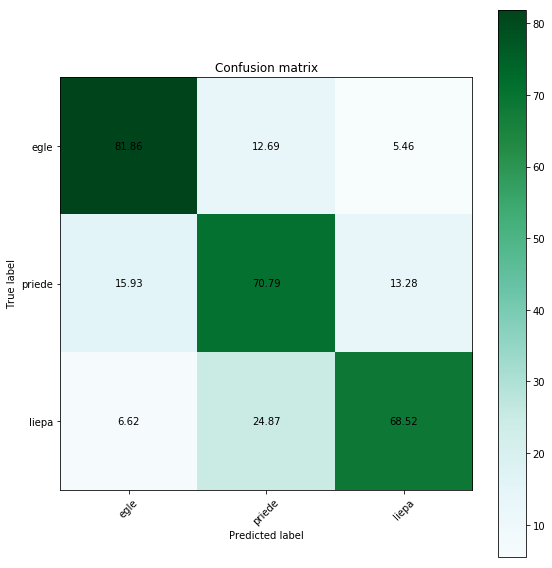

In [24]:
target_names = ['egle', 'priede', 'liepa']

# time_stamp = time.time()
# if not os.path.exists('reports/{}'.format(time_stamp)):
#     os.makedirs('reports/{}'.format(time_stamp))

plot_confusion_matrix(
    np.argmax(valid_labels, axis=1),
    flat_preds,
    target_names,
    cmap=plt.cm.BuGn
)

In [27]:
import json

norms_int = {}

for key, val in NORMS.items():
    norms_int[key] = [int(_val) for _val in val]
stats = {'norms': norms_int, 'maps': CLASS_MAPS}

with open('inference_model/stats.json', 'w') as outfile:
    json.dump(stats, outfile)
    print('Stats saved')

save_keras_model(keras_model, 'inference_model/')

Stats saved
Keras json model saved. inference_model/model.json
Keras h5 model saved. inference_model/model.h5


In [36]:
test_generator = Generator(
    class_maps=CLASS_MAPS,
    norms=NORMS,
    nb_time=1,
    reg_size=15,
    vegetation_layers=False,
    data_dir='../data/0510_extra_sentinel1/',
    batch_size=10000,
    batch_size_polygons=1000
)

test_gen = test_generator.from_files(norm=True, augment=False, match_dir_name='ds_' + str(189))
test_data, test_labels = next(test_gen)

print(f'{test_data.shape}')

2018-06-05 19:14:43,862 INFO: number of directories found 1


(303, 1, 15, 15, 12)


In [38]:
np.argmax(keras_model.predict(test_data), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [39]:
print(np.argmax(test_labels, axis=1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


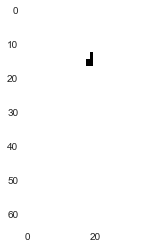

In [101]:
x_test = test_set.input_data[0][0, :, :, -1].copy()

x_test[x_test > 0] = np.argmax(keras_model.predict(test_set.train_data), axis=1)
plt.imshow(x_test * 50)